In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage as nd
import time

In [16]:
'''Searches for two extreme points in a circumference in a given coordinate x or y. 
Returns the opposite coordinates of the two ends of the a chord parallel to the given axis'''

def borderPoints(image, theresold, coord, axis = 'y', border = 30, epsilon = 5):
    # image -> np.array, represents the border image
    # theresold -> float [0, 255], represents the theresold value to consider
    # coord -> integer, represents the row/column to navigate with
    # axis -> str, represents the axis to navigate with
    
    points = []
    startPoint = None
    endPoint = None
    
    if axis == 'y':
        img = image[:, coord]
    else:
        img = image[coord, :]
    print(img)
    
    
    for i in range(border, img.size - border):
        print(img[i])
        if img[i] > theresold:
            startPoint = i
            break
        
    for j in range(img.size - border, border, -1):
        if img[j] > theresold:
            endPoint = j
            break
            
    return (startPoint, endPoint)

In [22]:
'''Returns the center coordinates of a circumference.'''

def centerDetect(image, theresold = 100, searchExactPoint = None, axis = 'x', found = False, searchLimit = 10):
    
    if searchExactPoint is None:
        size = (image.shape[1] if axis == 'y' else image.shape[0])
    else:
        startPoint, endPoint = borderPoints(image, theresold, searchExactPoint, axis)
        radii = (endPoint - startPoint)//2
        center = startPoint + radii
        return (center, radii, startPoint is not None, (startPoint, endPoint, searchExactPoint))
    
    # Buscar un punto de referencia en el borde de la circunferencia
    if not found:
        for i in range(2, searchLimit):
            step = size//i
            for j in range(1, i):
                other = step*j
                print('Searching coord {0}/{1}'.format(other, size))
                startPoint, endPoint = borderPoints(image, theresold, other, axis)
                if startPoint is not None:
                    found = True
                    break
        
    radii = (endPoint - startPoint)//2
    center = startPoint + radii
    return (center, radii, found, (startPoint, endPoint, other))

In [13]:
'''Applies the canny detector and center detect to find the iris center and radii.'''

def pupilDetector(img, theresold = 50):
    # img -> scipy.ndimage.ndarray, full color or grayscale image
    
    startTime = time.time()
    
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    thresh, BinaryImage = cv2.threshold(grayImage, theresold, 255, cv2.THRESH_BINARY)
    
    blur = cv2.GaussianBlur(BinaryImage,(5,5), 0) #Gaussian Smoothing, kernel 5x5, standard deviation (x, y) 0
    
    canny = cv2.Canny(blur, 400, 500) #Algoritmo de Canny para la deteccion de bordes, theresold (Hi/Lo) 100/200
    
    center_y, r, f, y_points = centerDetect(canny)
    detectedY = np.copy(canny)
    cv2.circle(detectedY, (y_points[2], y_points[0]), 3, (255, 255, 255), 3)
    cv2.circle(detectedY, (y_points[2], y_points[1]), 3, (255, 255, 255), 3)
    cv2.line(detectedY, (y_points[2], 0), (y_points[2], img.shape[0]), (255, 255, 255), 2)
    cv2.line(detectedY, (0, center_y), (img.shape[1], center_y), (255, 255, 255), 2)
    
    center_x, radii, f, x_points = centerDetect(canny, searchExactPoint = center_y, axis = 'x')
    detectedX = np.copy(canny)
    cv2.circle(detectedX, (x_points[0], x_points[2]), 3, (255, 255, 255), 3)
    cv2.circle(detectedX, (x_points[1], x_points[2]), 3, (255, 255, 255), 3)
    cv2.line(detectedX, (0, x_points[2]), (img.shape[1], x_points[2]), (255, 255, 255), 2)
    cv2.line(detectedX, (center_x, x_points[2]+radii+10), (center_x, x_points[2]-radii-10), (255, 255, 255), 2)
    
    pupil = np.copy(canny)
    cv2.circle(pupil, (center_x, center_y), radii, (255, 255, 255), 3)
    cv2.line(pupil, (center_x+radii//3, x_points[2]), (center_x-radii//3, x_points[2]), (255, 255, 255), 2)
    cv2.line(pupil, (center_x, x_points[2]+radii//3), (center_x, x_points[2]-radii//3), (255, 255, 255), 2)
    
    detectedPupil = np.copy(img)
    cv2.circle(detectedPupil, (center_x, center_y), radii, (255, 255, 255), 3)
    cv2.line(detectedPupil, (center_x+radii//3, x_points[2]), (center_x-radii//3, x_points[2]), (255, 255, 255), 2)
    cv2.line(detectedPupil, (center_x, x_points[2]+radii//3), (center_x, x_points[2]-radii//3), (255, 255, 255), 2)
    
    pupil_coords, pupil_radii = (center_x, center_y), radii
    
    print("Time (ms): {}".format((time.time()-startTime)*1000))
    
    return img, grayImage, BinaryImage, blur, canny, detectedY, detectedX, pupil, detectedPupil, pupil_coords, pupil_radii

In [14]:
'''Given a pupil, detects the iris using the integrodifferential operator and LBF + Ransac.'''

def irisDetector(img, pupil_coords, pupil_radii, margin = 5, min_iris_size = 30,
                 angle = np.pi/6, rad_margin = 5, experimental = False):
    # image -> np.array, represents the grayscale image
    # pupil_coords -> integer tuple, pupil raw center
    # pupil_radii -> integer, pupil raw radii
    # margin -> integer, search box size around the raw center
    # min_iris_size -> integer, minimum distance between iris and pupil radii
    # angle -> float, max = pi/2
    
    if angle > np.pi/2:
        raise Exception('Angle limit exceeded: Angle value should be in (0, pi/2])')
    
    startTime = time.time()
    
    x_max, y_max = img.shape
    maxRadii = min(pupil_coords[0], x_max - pupil_coords[1], 
                   pupil_coords[1], y_max - pupil_coords[0]) - margin
    
    buffer, X, Y, R = 0, 0, 0, 0
    
    arr = np.zeros((2*margin + 1, 2*margin + 1, maxRadii - pupil_radii - min_iris_size), np.int8)
    
    #Crea un arreglo con los valores medios de cada circunferencia#
    for r in range(pupil_radii + min_iris_size, maxRadii): #Iris DEBE caber en el cuadro
        y_range = int(r*np.sin(angle)) #Limites (max/min) del borde del iris en y
        r_max = r
        for i in range(pupil_coords[1] - margin, pupil_coords[1] + margin):
            for j in range(pupil_coords[0] - margin, pupil_coords[0] + margin):
                suma, cnt = 0, 0
                for y in range(-y_range, y_range):
                    x = int(np.sqrt(r**2 - y**2))
                    suma += img[x + i, y + j] + img[i - x, y + j]
                    cnt += 2
                arr[i - pupil_coords[1] + margin, j - pupil_coords[0] + margin, r - pupil_radii - min_iris_size] = suma/cnt
    
    argmax = np.zeros((arr.shape[2], 2))
    maxVal = np.zeros(arr.shape[2])
    
    #Agrega a arreglo argmax las diferencias radiales entre pixeles.#
    for r in range(arr.shape[2]):
        #Consideramos un margen de rad_margin de ancho radial, por lo que hacemos padding equivalente
        val = 0
        #Experimental suma los cambios entre pixeles radiales de paso 1
        if experimental:
            for rad in range(r - rad_margin, r + rad_margin + 1):
                if rad < 0 or rad > arr.shape[2] - 1:
                    val += np.zeros(arr[:,:,r].shape, dtype = 'int8')
                else:
                    val += arr[:,:,rad] - arr[:,:,rad - 1]
        #No experimental ve cambios radiales simetricos a r
        else:
            for i in range(rad_margin + 1):
                if r - i < 0 or r + i > arr.shape[2] - 1:
                    val += np.zeros(arr[:,:,r].shape, dtype = 'int8')
                else:
                    val += arr[:,:,r + i] - arr[:,:,r - i]
        arr_r = val
        argPos = np.argmax(arr_r)
        argmax[r] = (argPos//arr_r.shape[0], int(argPos%arr_r.shape[0])) #Rescato x e y con mayor cambio
        maxVal[r] = arr_r[int(argmax[r][0]), int(argmax[r][1])] #Almaceno el valor maximo, ubicado en x, y
    
    absoluteMax = np.argmax(maxVal)
    x_pos, y_pos = tuple(argmax[absoluteMax])
    
    print("Time (s): {}".format(time.time()-startTime))
        
    return (int(x_pos) + pupil_coords[0] - margin, 
            int(y_pos) + pupil_coords[1] - margin, 
            absoluteMax + pupil_radii + min_iris_size)

Searching coord 120/240
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

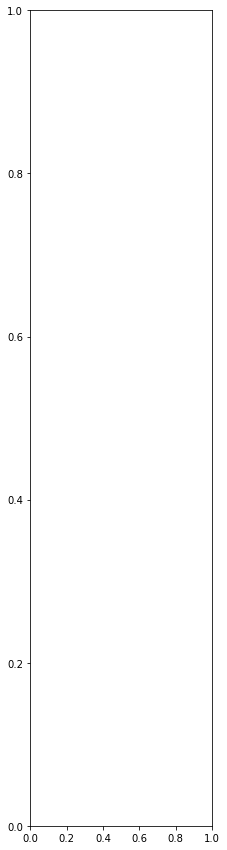

In [23]:
path = '/media/dela/1TB/A Universidad/Electrica/VIII Sem/Procesamiento Digital de Imagenes/IrisRec/IrisRecognition/IrisTestImages/'
imageList = ['iris4.bmp', 'iris5.bmp', 'iris6.bmp', 'iris7.bmp',
             'iris8.bmp', 'iris9.bmp', 'iris10.bmp', 'iris11.bmp']

fig=plt.figure(figsize=(15, 15))

x = 1
y = 0
for imageName in imageList:
    x  = (x%4) + 1
    if x == 2:
        y += 1
    fig.add_subplot(y, 4, x)
    image = mpimg.imread(path + imageName)

    img, grayImage, BinaryImage, blur, canny, detectedY, detectedX, pupil, detectedPupil, pupil_coords, pupil_radii = pupilDetector(image)

    iris = irisDetector(grayImage, pupil_coords, pupil_radii, angle = np.pi/6, rad_margin = 5, experimental=False)

    center_x, center_y, radii = iris
    detectedIris = np.copy(detectedPupil)
    cv2.circle(detectedIris, (center_x, center_y), radii, (255, 255, 255), 1)
    imgplot = plt.imshow(detectedIris, cmap = 'gray')
    plt.title(imageName)
    
plt.show()